# Stitching thermal drone imagery

In [ ]:
# Variable definition
imgDir = 'data/lsm/Flight 1 - Library/'
pathFile = 'data/lsm/Flight 1.csv'
utcDiff = -1
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)']
minAlt, maxAlt, altCol = 119.7, 120.3, 'altitude(m)'
imgTimes = [1619811011923,1619811099149] # Specify times if wanted
utmZone, hemisphere = '31n', 'north'
pxSize = 0.27 # pixel size (m) - for now
resolutions = [2, 6, 60]

In [2]:
# Import packages
#%pip install opencv-python
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
#import cv2 as cv

In [3]:
## Retrieve images and path information
imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(('.jpg','.png','.tif'))]
imgs.sort()
pathDf = pd.read_csv(pathFile)

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


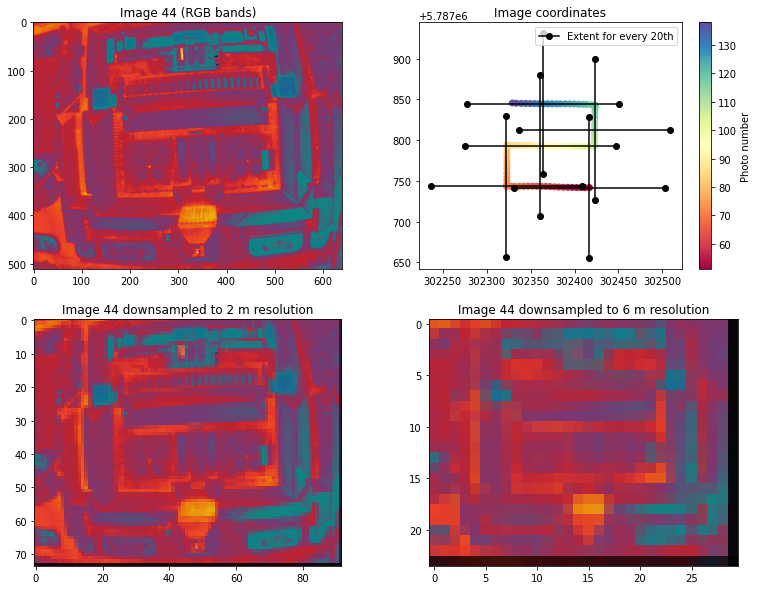

In [4]:
## Get corresponding GPS info matched with images
# Extract date and time from filenames
imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
# Convert to unix datetime 
imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+imgdates[i][:2]),int(imgdates[i][2:4]),int(imgdates[i][4:6]),int(imgtimes[i][:2])+utcDiff,int(imgtimes[i][2:4]),int(imgtimes[i][4:6])))) for i in range(len(imgs))])*1000
# Get nearest GPS timestamp
gpstimes = [min(pathDf['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes]
# Create image dataframe
imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
imgDf['timestamp'] = imgDf['timestamp'].astype(float)

# Merge with path dataframe
merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
# Filter for acceptable measurement altitudes
merged = merged.loc[(merged[altCol] > minAlt) & (merged[altCol] < maxAlt)]
if imgTimes: merged = merged.loc[(merged['timestamp'] > imgTimes[0]) & (merged['timestamp'] < imgTimes[1])]

# Convert coordinates to UTM
myProj = Proj('+proj=utm +zone='+utmZone+', +'+hemisphere+' +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
merged['x'], merged['y'] = myProj(merged['longitude'].values, merged['latitude'].values)

# Plot example image
imageNum = 44
fig, axs = plt.subplots(2,2,figsize=[13,10])
imgEx = ro.open(merged.iloc[44]['imgPath'])
imgExArr = np.dstack((imgEx.read()[0],imgEx.read()[1],imgEx.read()[2]))
a = axs[0,0].imshow(imgExArr.astype(np.uint8))
axs[0,0].set_title('Image {} (RGB bands)'.format(imageNum))

# Plot route
skip = 20
b = axs[0,1].scatter(merged.x,merged.y,c=merged.index, cmap='Spectral')
size = np.array(imgExArr.shape[:2])*pxSize/2
for i, row in merged[::skip].iterrows():
    axs[0,1].plot([row.x-size[1], row.x+size[1]], [row.y, row.y],'k-o')
    axs[0,1].plot([row.x, row.x],[row.y-size[1], row.y+size[1]],'k-o')
axs[0,1].set_title('Image coordinates')
axs[0,1].legend(labels=['Extent for every {}th'.format(skip)])
fig.colorbar(b, ax=axs[0,1],label='Photo number')

# Plot example downsampled image
for i, val in enumerate(resolutions):
    downsample = int(np.floor(val/pxSize))
    # first, change to 0-1
    ds_array = imgExArr/255
    r = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
    g = block_reduce(ds_array[:, :, 1], (downsample, downsample), np.mean)
    b = block_reduce(ds_array[:, :, 2], (downsample, downsample), np.mean)
    ds_array = np.stack((r, g, b), axis=-1)
    if i<2:
        c = axs[1,i].imshow(ds_array)
        axs[1,i].set_title('Image {} downsampled to {} m resolution'.format(str(imageNum),val))
plt.show()
fig.savefig('plots/Image{}.png'.format(str(imageNum)))

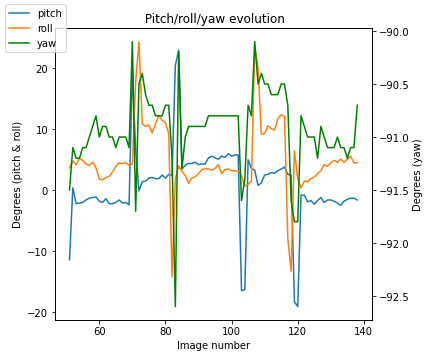

In [5]:
fig, ax = plt.subplots(1,1,figsize=[6,5])
ax.plot(merged.index,merged['pitch(deg)'],label='pitch')
ax.plot(merged.index,merged['roll(deg)'],label='roll')
par1 = ax.twinx()
par1.plot(merged.index,merged['yaw(deg)'],c='g',label='yaw')
ax.set_title(' Pitch/roll/yaw evolution')
ax.set_xlabel('Image number'), ax.set_ylabel('Degrees (pitch & roll)')
par1.set_ylabel('Degrees (yaw)')
fig.legend(loc='upper left')
plt.subplots_adjust(right=0.85)
fig.savefig('plots/pitchrollyaw.png')
fig.tight_layout()

In [90]:
del(xyvs)
xyvs = np.zeros([len(merged), 2])
xyvs[0,:] = merged.iloc[0][['x','y']]
for num, i in enumerate(merged.index[1:]):
    # Coordinates from initial and speed
    vels = pathDf.loc[pathDf.loc[pathDf['timestamp']==merged.loc[i-1]['timestamp']].index[0]:pathDf.loc[pathDf['timestamp']==merged.loc[i]['timestamp']].index[0]][['velocityX(mps)','velocityY(mps)','yaw(deg)']].mean()
    a = np.arctan(vels[1]/vels[0])
    v = np.hypot(vels[0],vels[1])#vels[1]/np.cos(a)# if np.cos(a) != 0 else vels[0]/np.sin(-a)
    #print(a)
    x = v*np.cos(np.deg2rad(90)-(np.deg2rad(vels[2])+a))
    y = v*np.sin(np.deg2rad(90)-(np.deg2rad(vels[2])+a))
    if x == 0: print(i)
    
    xyvs[num+1,:] = [xyvs[num,0]+x, xyvs[num,1]+y]
    
merged['xv'], merged['yv'] = xyvs[:,0], xyvs[:,1]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


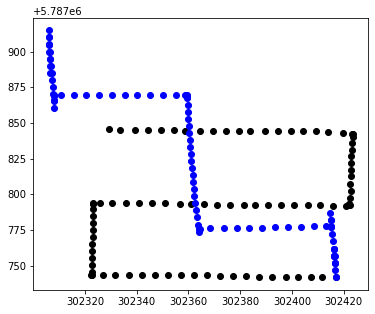

In [91]:
fig, ax = plt.subplots(1,1,figsize=[6,5])
ax.scatter(merged.x,merged.y,c='k',label='raw')
#ax.scatter(merged.xc,merged.yc,c='r',label='corrected')
ax.scatter(merged.xv,merged.yv,c='b',label='velocity')

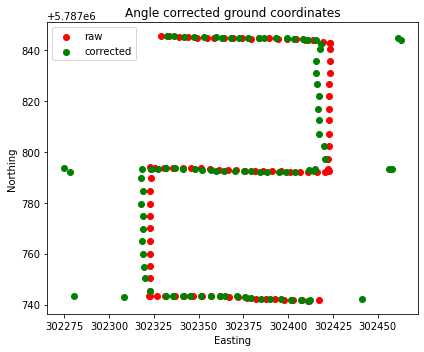

In [61]:
fig, ax = plt.subplots(1,1,figsize=[6,5])
ax.scatter(merged.x,merged.y,c='r',label='raw')
dist = merged['altitude(m)']*np.tan(np.deg2rad(merged['pitch(deg)']))
merged['xc'], merged['yc'] = merged.x+(dist*np.sin(np.deg2rad(merged['yaw(deg)']))), merged.y+(dist*np.cos(np.deg2rad(merged['yaw(deg)'])))
ax.scatter(merged['xc'],merged['yc'],c='g',label='corrected')
ax.legend()
ax.set_title('Angle corrected ground coordinates')
ax.set_xlabel('Easting'), ax.set_ylabel('Northing')
fig.tight_layout()
fig.savefig('plots/angleCorrectedcoords.png')


0it [00:00, ?it/s]
0it [00:00, ?it/s]
3it [00:00, 27.17it/s]

Number of images to process: 88.0



6it [00:00, 22.38it/s]
9it [00:00, 20.23it/s]
12it [00:00, 18.47it/s]
14it [00:00, 17.25it/s]
16it [00:00, 15.81it/s]
18it [00:01, 14.63it/s]
20it [00:01, 13.34it/s]
22it [00:01, 12.03it/s]
24it [00:01, 11.52it/s]
26it [00:01, 11.01it/s]
28it [00:02, 10.53it/s]
30it [00:02, 10.04it/s]
32it [00:02,  9.55it/s]
33it [00:02,  9.28it/s]
34it [00:02,  9.01it/s]
35it [00:02,  8.75it/s]
36it [00:03,  8.46it/s]
37it [00:03,  8.21it/s]
38it [00:04,  2.41it/s]
39it [00:04,  2.95it/s]
40it [00:04,  2.99it/s]
41it [00:04,  3.58it/s]
42it [00:05,  3.39it/s]
43it [00:05,  3.96it/s]
44it [00:05,  3.58it/s]
45it [00:05,  4.12it/s]
46it [00:06,  3.61it/s]
47it [00:08,  1.29it/s]
48it [00:08,  1.54it/s]
49it [00:08,  1.75it/s]
50it [00:09,  1.97it/s]
51it [00:09,  2.14it/s]
52it [00:10,  2.24it/s]
53it [00:10,  2.35it/s]
54it [00:10,  2.42it/s]
55it [00:11,  2.42it/s]
56it [00:11,  2.44it/s]
57it [00:12,  2.44it/s]
58it [00:12,  2.42it/s]
59it [00:12,  2.43it/s]
60it [00:13,  2.43it/s]
61it [00:13,  2.3

Number of images to process: 17.0



6it [00:00, 24.05it/s]
9it [00:00, 20.39it/s]
12it [00:00, 18.31it/s]
14it [00:00, 16.68it/s]
16it [00:00, 15.40it/s]
18it [00:01, 16.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

0it [00:00, ?it/s]
5it [00:00, 45.10it/s]
10it [00:00, 45.07it/s]
18it [00:00, 43.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

0it [00:00, ?it/s]
5it [00:00, 47.40it/s]
10it [00:00, 47.46it/s]
18it [00:00, 46.83it/s]

0it [00:00, ?it/s]
5it [00:00, 49.66it/s]
11it [00:00, 49.82it/s]
18it [00:00, 49.18it/s]
2it [16:10, 443.47s/it]
0it [00:00, ?it/s]
3it [00:00, 28.61it/s]

Number of images to process: 8.0



6it [00:00, 24.33it/s]
9it [00:00, 22.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

0it [00:00, ?it/s]
9it [00:00, 44.15it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

0it [00:00, ?it/s]
9it [00:00, 46.19it/s]

0it [00:00, ?it/s]
9it [00:00, 45.40it/s]
3it [18:09, 295.61s/it]
0it [00:00, ?it/s]
3it [00:00, 26.97it/s]

Number of images to process: 4.0


5it [00:00, 25.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

0it [00:00, ?it/s]
5it [00:00, 43.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

0it [00:00, ?it/s]
5it [00:00, 47.04it/s]

0it [00:00, ?it/s]
5it [00:00, 47.51it/s]
4it [25:22, 380.67s/it]


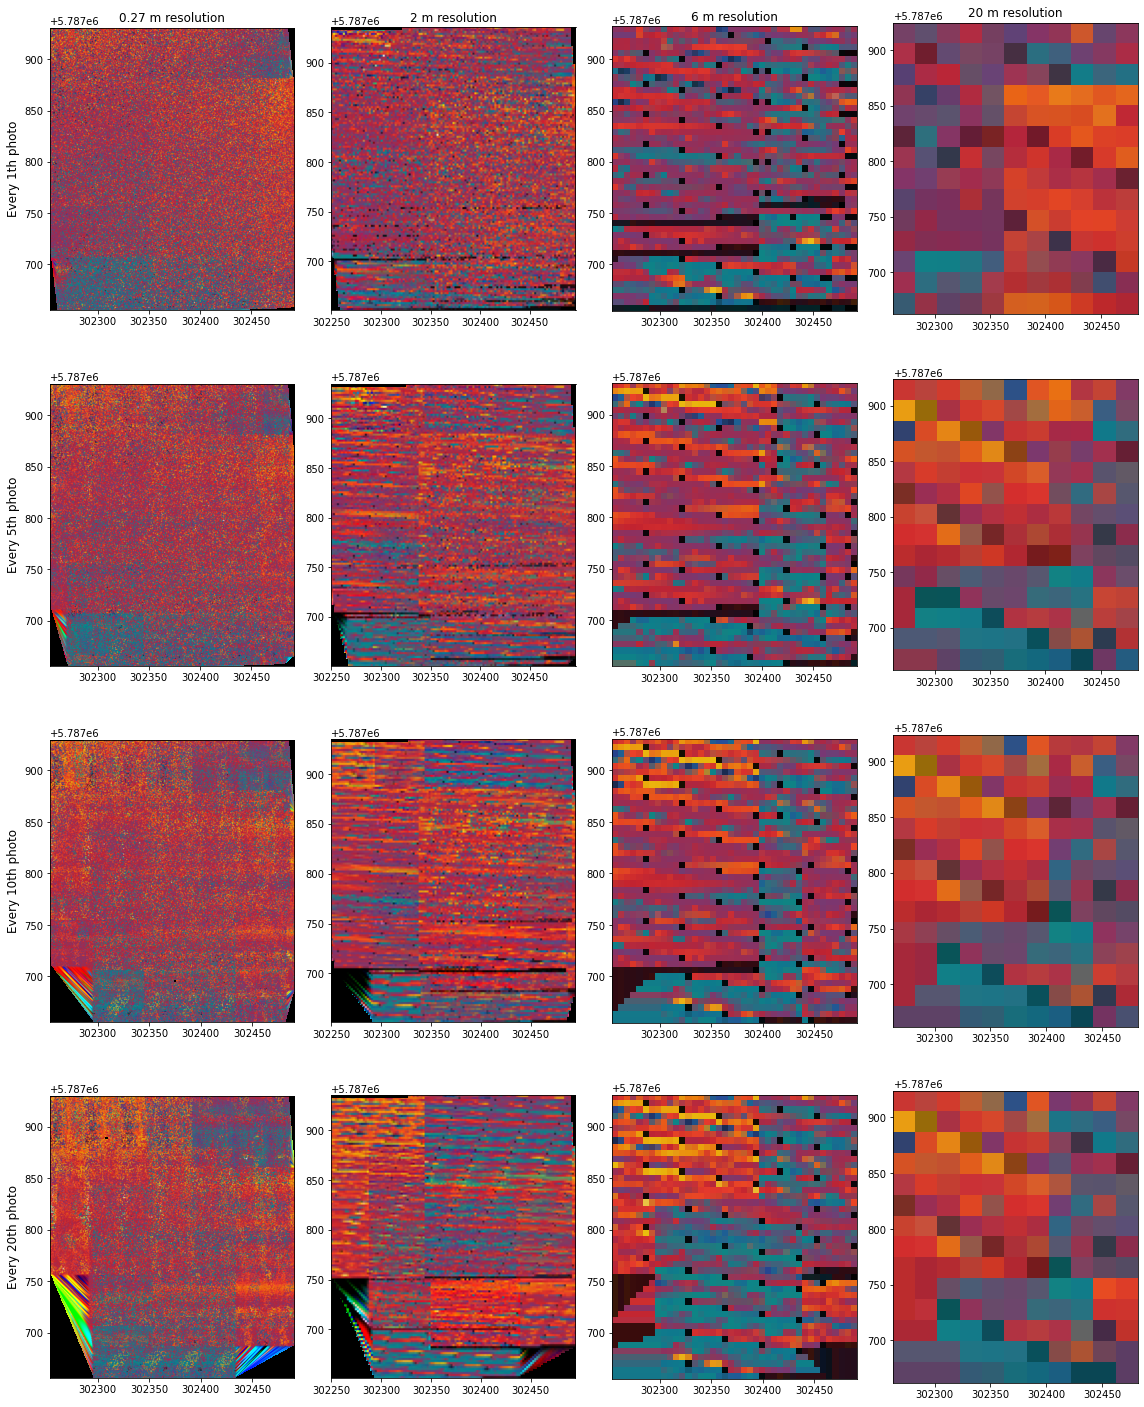

In [88]:
resolutions = [pxSize,2,6,20]
skips = [1,5,10,20]
fig, ax = plt.subplots(len(skips),len(resolutions),figsize=[4*len(resolutions),5*len(skips)])

# Loop over resolution to create combined image for each
for snum, skip in tqdm(enumerate(skips)):
    print('Number of images to process: '+str(np.floor(len(merged)/skip)))
    for num, val in enumerate(resolutions):
        # Define downsample
        downsample = int(np.floor(val/pxSize))
        ds_array = imgExArr/255
        rEx = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
        # Get x,y coordinates for each pixel
        xCoords, yCoords = [(np.array(range(rEx.shape[i]))-(rEx.shape[i]/2))*val+val/2 for i in [0,1]]
        xmCoords, ymCoords = np.meshgrid(xCoords,yCoords)
        xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)
        # Loop over images
        total = [0,0,0,0,0]
        for index, row in tqdm(merged[::skip].iterrows()):
            img = ro.open(row.imgPath)
            read = img.read()
            imgArr = np.dstack((read[0],read[1],read[2]))
            ds_array = imgArr/255
            r = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
            g = block_reduce(ds_array[:, :, 1], (downsample, downsample), np.mean)
            b = block_reduce(ds_array[:, :, 2], (downsample, downsample), np.mean)
            total = np.vstack((total, np.concatenate((xmcr+row.x, ymcr+row.y,r.reshape(-1,1),g.reshape(-1,1),b.reshape(-1,1)),axis=-1)))

        #allDf = pd.DataFrame(total[1:],columns=['x','y','r','g','b'])  
        # Convert to grid for image
        extent = (np.ceil(min(total[1:,0])), np.floor(max(total[1:,0])),np.ceil(min(total[1:,1])),np.floor(max(total[1:,1])))
        xsGrid = np.arange(extent[0], extent[1], val)
        ysGrid = np.arange(extent[2], extent[3], val)
        xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

        # Associate values with grid points by interpolation - Too slow, probs need something better than this
        method = 'cubic' if val < 3 else 'nearest'
        r,g,b = [griddata(total[1:,:2], total[1:,i], (xsGridm, ysGridm), method=method) for i in [2,3,4]]

        # Plot 
        a = ax[snum,num].imshow(np.dstack((r, g, b)),extent=extent)
        if snum==0: ax[0,num].set_title('{} m resolution'.format(val))
    ax[snum,0].set_ylabel('Every {}th photo'.format(skip), size='large')
fig.tight_layout()
#fig.savefig('plots/xystitch_allskipsNearest>3.png')

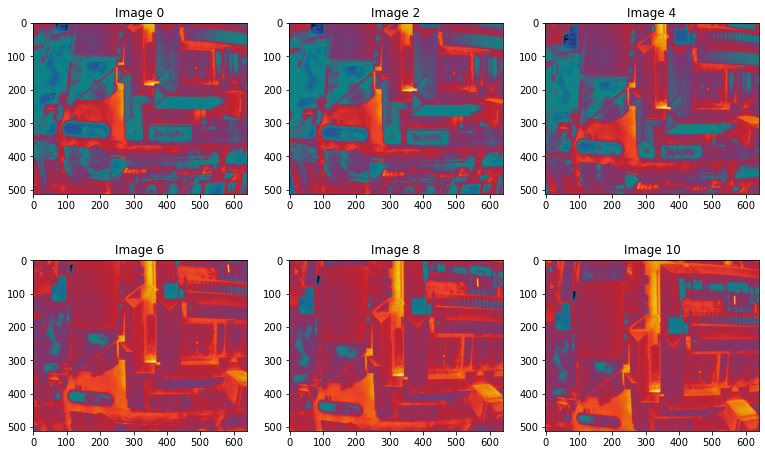

In [87]:
# Plot example images of change in same location
fig, axs = plt.subplots(2,3,figsize=[13,8])
for i in range(6):
    imgEx = ro.open(merged.iloc[i*2]['imgPath'])
    imgExArr = np.dstack((imgEx.read()[0],imgEx.read()[1],imgEx.read()[2]))
    row = 0 if (i<3) else 1
    a = axs[row,i-row*3].imshow(imgExArr.astype(np.uint8))
    axs[row,i-row*3].set_title('Image {}'.format(i*2))
fig.savefig('plots/first6images')

In [484]:
# Single image processing
total = [0,0,0,0,0]

print('Number of images to process: '+str(len(merged)))
for index, row in tqdm(merged.iterrows()):
    img = ro.open(row.imgPath)
    read = img.read()
    imgArr = np.dstack((read[0],read[1],read[2]))
    ds_array = imgArr/255
    r = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
    g = block_reduce(ds_array[:, :, 1], (downsample, downsample), np.mean)
    b = block_reduce(ds_array[:, :, 2], (downsample, downsample), np.mean)
    #ds_array = np.stack((r, g, b), axis=-1)
    total = np.vstack((total, np.concatenate((xmcr+row.x, ymcr+row.y,r.reshape(-1,1),g.reshape(-1,1),b.reshape(-1,1)),axis=-1)))
allDf = pd.DataFrame(total[1:],columns=['x','y','r','g','b']) 

## Get point grid with GPS info
imgSize = imgEx.read().shape
xCoords, yCoords = [(np.array(range(imgSize[i]))-(imgSize[i]/2))*pxSize+pxSize/2 for i in [1,2]]
xmCoords, ymCoords = np.meshgrid(xCoords,yCoords)
xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)

total = [0,0,0,0,0]

print('Number of images to process: '+str(len(merged)))
for index, row in tqdm(merged.iterrows()):
    img = ro.open(row.imgPath)
    total = np.vstack((total, np.concatenate((xmcr+row.x, ymcr+row.y,img.read().reshape(-1,3)),axis=-1)))
allDf = pd.DataFrame(total[1:],columns=['x','y','r','g','b']) 

# Convert to grid for image
extent = (np.ceil(min(allDf.x)), np.floor(max(allDf.x)),np.ceil(min(allDf.y)),np.floor(max(allDf.y)))
xsGrid = np.arange(extent[0], extent[1], resolution)
ysGrid = np.arange(extent[2], extent[3], resolution)
xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

# Associate values with grid points by interpolation - Too slow, probs need something better than this
r,g,b = [griddata(total[1:,:2], total[1:,i], (xsGridm, ysGridm), method='cubic') for i in [2,3,4]]

# Plot 
fig, ax = plt.subplots(1,1,figsize=[5,8])
a = ax.imshow(np.dstack((r, g, b)),extent=extent)

2it [00:00, 19.65it/s]

Number of images to process: 88


88it [00:02, 34.19it/s]


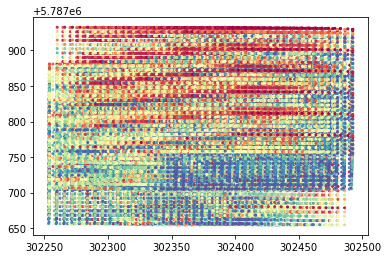

In [501]:
# Plot just 1 band
plt.scatter(total[1:,0],total[1:,1],c=total[1:,2],s=4,cmap='Spectral')